# **Imports**

In [1]:
import numpy as np
import pandas as pd
import math
import cv2
import time
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objs as go
from six import StringIO
from IPython.display import Image, clear_output,display,HTML

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn import datasets as dt
from sklearn import preprocessing as pp

from sklearn import linear_model as lm 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree as tr
from sklearn.ensemble import RandomForestClassifier 
from sklearn import cluster as ct

## **Functions**

In [3]:
def class_separator(df,model,negative_class_proportion,positive_class_proportion):
    
    # Separar as classes
    conceder_df = df[df['limite_adicional'] == 'Conceder']
    negar_df = df[df['limite_adicional'] == 'Negar']
    
    # Definir o tamanho total desejado para o novo dataset balanceado
    total_size = min(len(conceder_df) * 10 // positive_class_proportion, len(negar_df) * 10 // negative_class_proportion)  
    
    # Calcular o número de amostras de cada classe
    num_conceder = total_size * positive_class_proportion // 10
    num_negar = total_size * negative_class_proportion // 10
    
    # Amostrar aleatoriamente a quantidade de registros calculada de cada classe
    conceder_sampled = conceder_df.sample(num_conceder, random_state=42)
    negar_sampled = negar_df.sample(num_negar, random_state=42)
    
    # Concatenar as amostras balanceadas
    df_new = pd.concat([conceder_sampled, negar_sampled])
    
    # Embaralhar os dados
    df_new = df_new.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # print(df_new['limite_adicional'].value_counts(normalize=True))

    # Seleção de Features
    features = ['idade', 'saldo_atual', 'divida_atual', 'renda_anual', 'valor_em_investimentos',
            'taxa_utilizacao_credito', 'num_emprestimos', 'num_contas_bancarias', 'num_cartoes_credito',
            'dias_atraso_dt_venc', 'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros']

    label = ['limite_adicional']
    
    # Preparação dos dados de treino
    X = df_new.loc[:, features]
    y = df_new.loc[:, label].values.ravel()
    
    x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    # Confusion Matrix
    cm = mt.confusion_matrix(y_test, y_pred)
    
    # Accuracy
    acc = mt.accuracy_score(y_test, y_pred)
    
    # Precisao
    prec = mt.precision_score(y_test, y_pred, average='binary', pos_label='Conceder')
    
    # Recall
    recall = mt.recall_score(y_test, y_pred, average='binary', pos_label='Conceder')
    
    # F1
    f1 = mt.f1_score(y_test, y_pred, average='binary', pos_label='Conceder') 

    return cm, acc, prec, recall, f1



def class_separator_2(model,negative_class_proportion,positive_class_proportion):

    X, y = (dt.make_classification(n_samples=5000, n_features=20, n_informative=2, n_redundant=10, n_classes=2, flip_y=0.08, 
                                  weights=([negative_class_proportion,positive_class_proportion]), random_state=42))
    
    x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    # Confusion Matrix
    cm = mt.confusion_matrix(y_test, y_pred)
    
    # Accuracy
    acc = mt.accuracy_score(y_test, y_pred)
    
    # Precisao
    prec = mt.precision_score(y_test, y_pred, average='binary')
    
    # Recall
    recall = mt.recall_score(y_test, y_pred, average='binary')
    
    # F1
    f1 = mt.f1_score(y_test, y_pred, average='binary') 

    return cm, acc, prec, recall, f1
    

def evaluate_classifier(classifier, proportions):
    results = {
        'Neg/pos class': [],
        'Acurácia': [],
        'Precisão': [],
        'Recall': [],
        'F1-Score': []}
    
    for neg_class_prop, pos_class_prop in proportions:
        cm, acc, prec, recall, f1 = class_separator_2(classifier, neg_class_prop, pos_class_prop)
        results['Neg/pos class'].append(f"{int(neg_class_prop*10)}/{int(pos_class_prop*10)}")
        results['Acurácia'].append(acc)
        results['Precisão'].append(prec)
        results['Recall'].append(recall)
        results['F1-Score'].append(f1)
    
    return pd.DataFrame(results)
    
    
def display_html(df1,df2,df3,df4):
    html = f"""
    <table>
        <tr>
            <td style="text-align: center; font-weight: bold;">{'knn'}</td>
            <td style="text-align: center; font-weight: bold;">{'logistic_regression'}</td>
        </tr>
        <tr>
            <td style="vertical-align: top;">
                {df1.to_html()}
            </td>
            <td style="vertical-align: top;">
                {df2.to_html()}
            </td>
        </tr>
        <tr>
            <td style="text-align: center; font-weight: bold;">{'decision_tree'}</td>
            <td style="text-align: center; font-weight: bold;">{'random_forest'}</td>
        </tr>
        <tr>
            <td style="vertical-align: top;">
                {df3.to_html()}
            </td>
            <td style="vertical-align: top;">
                {df4.to_html()}
            </td>
        </tr>
    </table>
    """
    
    return display(HTML(html))

# **Regressão**

## **Linear**

In [7]:
df = pd.read_csv('train.csv')
df.head(1)

# ver quantile regression = regressão que se ajusta a borda e nao ao centro, pode ser usada para criar intervalos de confiança (aula 56)
# tbm existe random forest de quartil

id_cliente  idade  saldo_atual  divida_atual  renda_anual  \
0        1767     21   278.172008       2577.05  24196.89636   

   valor_em_investimentos  taxa_utilizacao_credito  num_emprestimos  \
0              104.306544                31.038763                6   

   num_contas_bancarias  num_cartoes_credito  dias_atraso_dt_venc  \
0                     5                    7                   21   

   num_pgtos_atrasados  num_consultas_credito  taxa_juros investe_exterior  \
0                   14                      9          15              Não   

  pessoa_polit_exp limite_adicional  
0              Não            Negar

In [8]:
# Seleção de Features
features = ['idade', 'divida_atual', 'renda_anual', 'valor_em_investimentos',
'taxa_utilizacao_credito', 'num_emprestimos', 'num_contas_bancarias', 'num_cartoes_credito',
'dias_atraso_dt_venc', 'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros']

# Variável alvo
label = ['saldo_atual']

# Dados de treinamento e teste
x_train = df.loc[:, features]
y_train = df.loc[:, label]

# Treinamento do algoritmo
lr_model = lm.LinearRegression().fit(x_train, y_train)

# Previsão do algoritmo
y_pred = lr_model.predict(x_train)

# Resultado final
df1 = df.loc[:, ['id_cliente', 'saldo_atual']]
df1['predicted'] = y_pred
df1.head()

id_cliente  saldo_atual   predicted
0        1767   278.172008  346.669549
1       11920   268.874152  367.840277
2        8910   446.643127  431.468979
3        4964   321.141267  445.506463
4       10100   428.716114  378.271169

## **R2**

In [21]:
r2_squared = np.round(100*mt.r2_score(y_train, y_pred), 2)
print('R2 square: {}%'.format(r2_squared))

# as variáveis explicam 17% do dataset

R2 square: 16.92%


## **Overfitting**

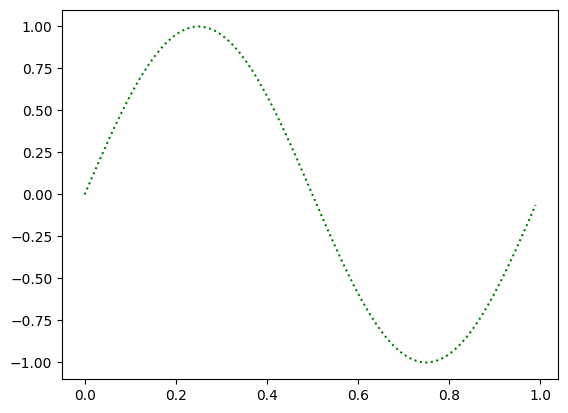

In [23]:
# synthetic regression dataset
# math.sin = função senoidal que faz uma onda
# 2*pi = fórmula do seno
# x é um parâmetro que será passado na função
hidden_law = np.vectorize(lambda x: math.sin(2*math.pi*x))

x_all = np.arange(0, 1, 0.01)
y_hidden = hidden_law(x_all)

# senoide (nesse exemplo é a 'fonte geradora', que é de onde o comportamento a ser modelado se origina)
plt.plot(x_all, y_hidden, ':g');

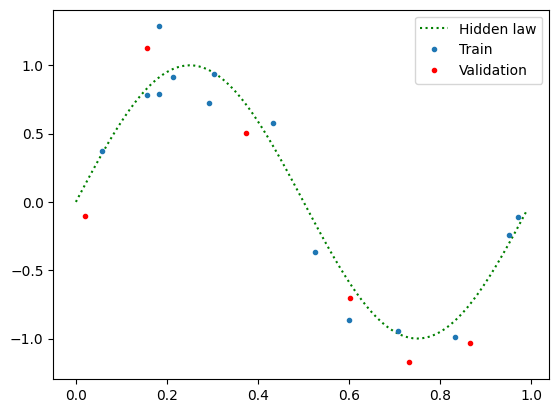

In [27]:
np.random.seed(42)
noise = 0.2
samples = 20

# dataset
x = np.random.rand(samples)
y = np.sin(2*np.pi*x) + noise*np.random.randn(samples)

# split training and test dataset
x_train, x_val, y_train, y_val = ms.train_test_split(x, y, test_size=0.3)

plt.plot(x_all, y_hidden, ':g')
plt.plot(x_train, y_train, '.')
plt.plot(x_val, y_val, 'r.')
plt.legend(['Hidden law', 'Train', 'Validation']);

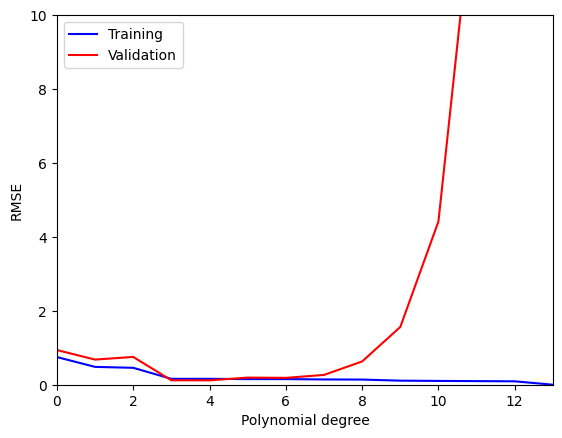

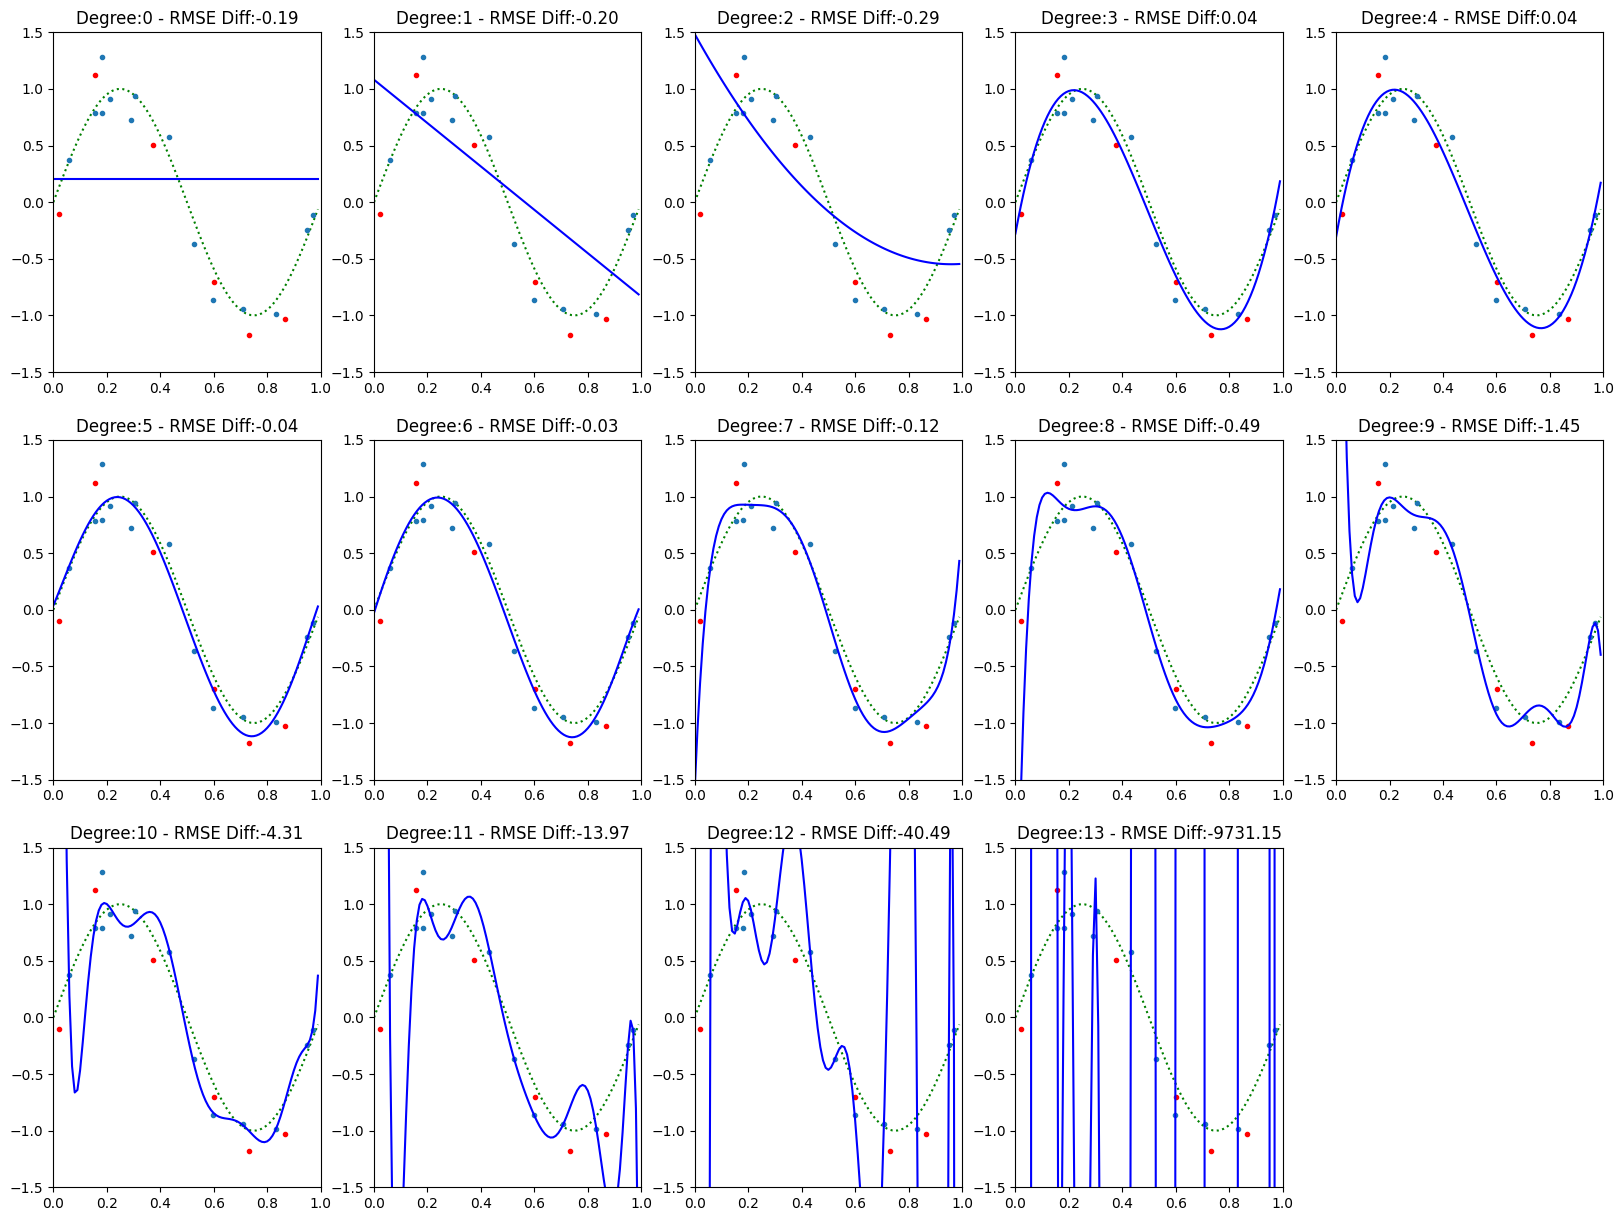

In [33]:
# ## Treinamento
max_poly_degree = 14
poly_degrees = range(max_poly_degree)
polys = []

for p in poly_degrees:
    # np.polyfit faz o ajuste de um polinômio (modelo de regressão polinomial)
    # usa-se esse modelo para ser possível observar o overfitting em diferentes parâmetros(polinômios)
    poly_model = np.polyfit(x_train, y_train, p)
    polys.append(poly_model)

# lista de zeros do mesmo tamanho demax_poly_degree (14) que serão substitutídos pelo erro equivalente
rmse_train = np.zeros(max_poly_degree)
rmse_val = np.zeros(max_poly_degree)

for p in poly_degrees:
    # predict over training dataset
    yhat_train = np.polyval(polys[p], x_train)
    
    # rmse feito à mão
    rmse_train[p] = np.sqrt(np.mean(np.square(yhat_train - y_train)))
    
    # predict over validation dataset
    yhat_val = np.polyval(polys[p], x_val)
    rmse_val[p] = np.sqrt(np.mean(np.square(yhat_val - y_val)))
        
plt.plot(poly_degrees, rmse_train, 'b')
plt.plot(poly_degrees, rmse_val, 'r')
plt.axis((0, max_poly_degree-1, 0, 10))
plt.legend(['Training', 'Validation'])
plt.xlabel('Polynomial degree')
plt.ylabel('RMSE');

plt.figure(figsize=(20,15))
for p in poly_degrees:
    plt.subplot(3, 5, p+1)
    y_pol = np.polyval(polys[p], x_all)
    plt.plot(x_all, y_hidden, ':g')
    plt.plot(x_train, y_train, '.')
    plt.plot(x_val, y_val, 'r.')
    plt.plot(x_all, y_pol, 'b')
    plt.title('Degree:{} - RMSE Diff:{:.2f}'.format(p,rmse_train[p]-rmse_val[p]))
    plt.axis((0, 1, -1.5, 1.5))

# polinômio = 0 é um valor constante (reta)
# polinômio = 1 é a regressão linear
# polinômios mais altos têm viés baixo e alta variância (overfitting) (as retas estão passando literalmente em cima dos pontos azuis (treino))

## **Regularização**

Coef used to create the data 16.748258225906977
Linear regression coef       [11.18803742]
Lasso coef                   [7.38080206] alpha = 5
Ridge coef                   [11.14560348] alpha = 5
Elastic net coef             [3.1975352] alpha = 5
Ransac coef                  [16.06145012]


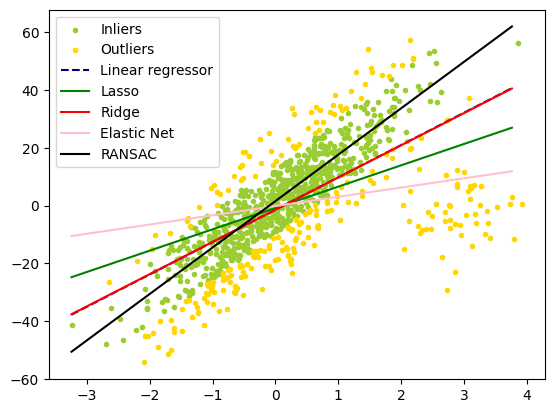

In [77]:
# =========== Loading dataset ===========
n_samples = 1000
n_outliers = 50
X, y, coef = dt.make_regression(n_samples=n_samples,n_features=1,n_informative=1,noise=10,coef=True,random_state=42)

np.random.seed(42)

# adicionar e definir onde os outliers estarão localizados
## X[:n_outliers] = adicionando 50 outliers após o último ponto
## 3 = perto do canto inferior direito (pq os dados originais vão até 2)
## 0.5 = variação 
## np.random.normal = variação criada nos novos pontos (os pontos adicionados terão distribuição normal (maior probabilidade de ocorrer perto da média))
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))

y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# =========== Modeling ===========
# Linear Model
lr = lm.LinearRegression()
lr.fit(X, y)

# Lasso/l1 (tende a zerar os parâmetros) (um valor pequeno de alpha altera facilmente a reta)
## alpha = constante controla a força da regularização (não usar = 0 (se torna equivalente ao método dos mínimos quadrados = regressão linear))
lasso = lm.Lasso(alpha=5)
lasso_alpha=lasso.get_params()
lasso_alpha=lasso_alpha['alpha']
lasso.fit(X, y)

# Ridge/l2 (smoothing =  amenização dos parâmetros) (um valor alto de alpha causa pouca alteração)
ridge = lm.Ridge(alpha=5)
ridge_alpha=ridge.get_params()
ridge_alpha=ridge_alpha['alpha']
ridge.fit(X, y)

# Elastic Net l1/l2 
elastic_net = lm.ElasticNet(alpha=5, l1_ratio=0.5)
# l1_ratio: 0 < l1_ratio < 1 = combinação de l1 e l2 | l1_ratio = 0 = l2 | l1_ratio = 1 = l1   
elastic_alpha=elastic_net.get_params()
elastic_alpha=elastic_alpha['alpha']
elastic_net.fit(X, y)

# RANSAC (possui um identificar de outlier)
ransac = lm.RANSACRegressor(stop_n_inliers=950)
ransac.fit(X, y)
# valores que o ransac identificar como normais e outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# predict/dados teste
## np.arange(X.min(), X.max() = criando o novo dataset com valores entre o mínimo e o máximo dos dados de treino
## np.newaxis = empilhar os arrays criados
X_plot = np.arange(X.min(), X.max())[:, np.newaxis]
#X_plot = X

y_linear_model = lr.predict(X_plot)
y_lasso = lasso.predict(X_plot)
y_ridge = ridge.predict(X_plot)
y_elastic = elastic_net.predict(X_plot)
y_ransac = ransac.predict(X_plot)

# =========== Coeficients ===========
print(f'Coef used to create the data {coef}') # na prática valores desconhecidos
print(f'Linear regression coef       {lr.coef_}')
print(f'Lasso coef                   {lasso.coef_} alpha = {lasso_alpha}')
print(f'Ridge coef                   {ridge.coef_} alpha = {ridge_alpha}')
print(f'Elastic net coef             {elastic_net.coef_} alpha = {elastic_alpha}')
print(f'Ransac coef                  {ransac.estimator_.coef_}')


# =========== Plots ===========
plt.scatter(X[inlier_mask],y[inlier_mask], color="yellowgreen", marker=".", label="Inliers")
plt.scatter(X[outlier_mask],y[outlier_mask], color="gold", marker=".", label="Outliers")

plt.plot(X_plot, y_linear_model, color="navy", linestyle="--", label="Linear regressor");
plt.plot(X_plot, y_lasso, color="green", label="Lasso");
plt.plot(X_plot, y_ridge, color="red", label="Ridge");
plt.plot(X_plot, y_elastic, color="pink", label="Elastic Net");
plt.plot(X_plot, y_ransac, color="black", label="RANSAC");
plt.legend();

In [43]:
# =========== Loading dataset ===========
n_samples = 1000
n_outliers = 50
X, y, coef = dt.make_regression(n_samples=n_samples,n_features=6,n_informative=2,noise=10,coef=True,random_state=42)

np.random.seed(42)

# adicionar e definir onde os outliers estarão localizados
## X[:n_outliers] = adicionando 50 outliers após o último ponto
## 3 = perto do canto inferior direito (pq os dados originais vão até 2)
## 0.5 = variação 
## np.random.normal = variação criada nos novos pontos (os pontos adicionados terão distribuição normal (maior probabilidade de ocorrer perto da média))
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))

y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# =========== Modeling ===========
# Linear Model
lr = lm.LinearRegression()
lr.fit(X, y)

# Lasso/l1 (tende a zerar os parâmetros) (um valor pequeno de alpha altera facilmente a reta)
## alpha = constante controla a força da regularização (não usar = 0 (se torna equivalente ao método dos mínimos quadrados = regressão linear))
lasso = lm.Lasso(alpha=20)
lasso.fit(X, y)

# Ridge/l2 (smoothing =  amenização dos parâmetros) (um valor alto de alpha causa pouca alteração)
ridge = lm.Ridge(alpha=200)
ridge.fit(X, y)

# Elastic Net l1/l2 
elastic_net = lm.ElasticNet(alpha=20)
elastic_net.fit(X, y)

# RANSAC (possui um identificar de outlier)
ransac = lm.RANSACRegressor(stop_n_inliers=950)
ransac.fit(X, y)
# valores que o ransac identificar como normais e outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# predict/dados teste
## np.arange(X.min(), X.max() = criando o novo dataset com valores entre o mínimo e o máximo dos dados de treino
## np.newaxis = empilhar os arrays criados
X_plot = np.arange(X.min(), X.max())[:, np.newaxis]
#X_plot = X

# y_linear_model = lr.predict(X_plot)
# y_lasso = lasso.predict(X_plot)
# y_ridge = ridge.predict(X_plot)
# y_ransac = ransac.predict(X_plot)

# =========== Coeficients ===========
print(f'Coef used to create the data {list(coef)}') # na prática valores desconhecidos
print(f'Linear regression coef       {lr.coef_}')
print(f'Lasso coef                   {lasso.coef_}')
print(f'Ridge coef                   {ridge.coef_}')
print(f'Elastic net coef             {elastic_net.coef_}')
print(f'Ransac coef                  {ransac.estimator_.coef_}')


# # =========== Plots ===========
# plt.scatter(X[inlier_mask],y[inlier_mask], color="yellowgreen", marker=".", label="Inliers")
# plt.scatter(X[outlier_mask],y[outlier_mask], color="gold", marker=".", label="Outliers")

# plt.plot(X_plot, y_linear_model, color="navy", label="Linear regressor");
# plt.plot(X_plot, y_lasso, color="green", label="Lasso");
# plt.plot(X_plot, y_ridge, color="red", label="Ridge");
# plt.plot(X_plot, y_ransac, color="black", label="RANSAC");
# plt.legend();

Coef used to create the data [33.64503518175101, 0.0, 0.0, 0.0, 21.12082585879517, 0.0]
Linear regression coef       [26.05059642 -6.19534897 -6.72829835 -6.72397001 14.50050207 -6.74327969]
Lasso coef                   [ 7.03909894 -0.         -0.         -0.          0.         -0.        ]
Ridge coef                   [21.60144871 -4.78518007 -5.13377228 -5.40998469 12.39219609 -5.35622023]
Elastic net coef             [ 1.65447791 -0.         -0.         -0.          0.84633872 -0.        ]
Ransac coef                  [35.10562357  0.78975154 -0.56594313 -0.4169426  22.26419747 -0.76374391]


## **Polinomial**

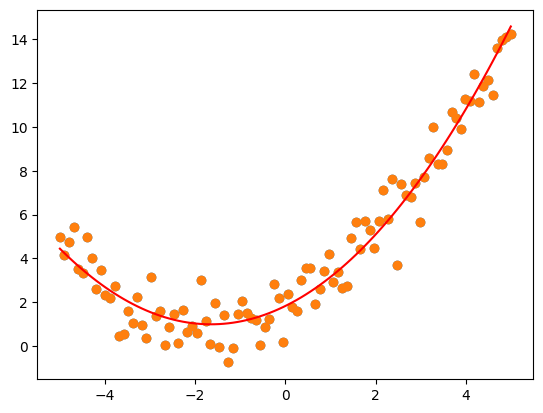

In [11]:
# Dataset
np.random.seed(42)

# n° de dados
m = 100

# 100 valores entre -5 e 5
X = np.linspace(-5, 5, num=m)

# comportamento nao linear de grau 2 (quadrático)
## beta = 0.3
y = 0.3*X**2 + X + 2 + np.random.normal(size=m)
plt.scatter(X, y)

# Model Training
# Incluir termos polinomiais de grau 2
poly = pp.PolynomialFeatures(degree=2, include_bias=False)
# X.reshape(-1, 1) transforma em array
X_poly = poly.fit_transform(X.reshape(-1, 1))

# model training
model = lm.LinearRegression().fit(X_poly, y)

# predict
yhat = model.predict(X_poly)

# plot
plt.scatter(X, y)
plt.plot(X, yhat, color='red');

### **Graus**

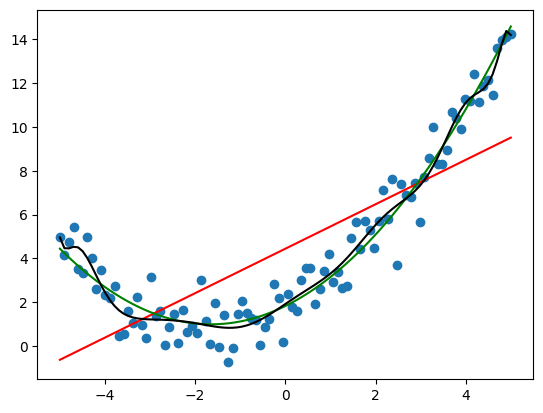

In [13]:
# Graus do polinômio
degrees = [1, 2, 15]
coefs = []
intercepts = []
preds = []

for i in degrees:
    # features
    poly_features = pp.PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly_features.fit_transform(X.reshape(-1, 1))
    
    # model training
    model = lm.LinearRegression()
    model.fit(X_poly, y)
    
    # model predict
    yhat = model.predict(X_poly)
    preds.append(yhat)
    
# Visualização dos gráficos
plt.scatter(X, y);
plt.plot(X, preds[0], color='red');
plt.plot(X, preds[1], color='green');
plt.plot(X, preds[2], color='black');

### **Decision boundaries**

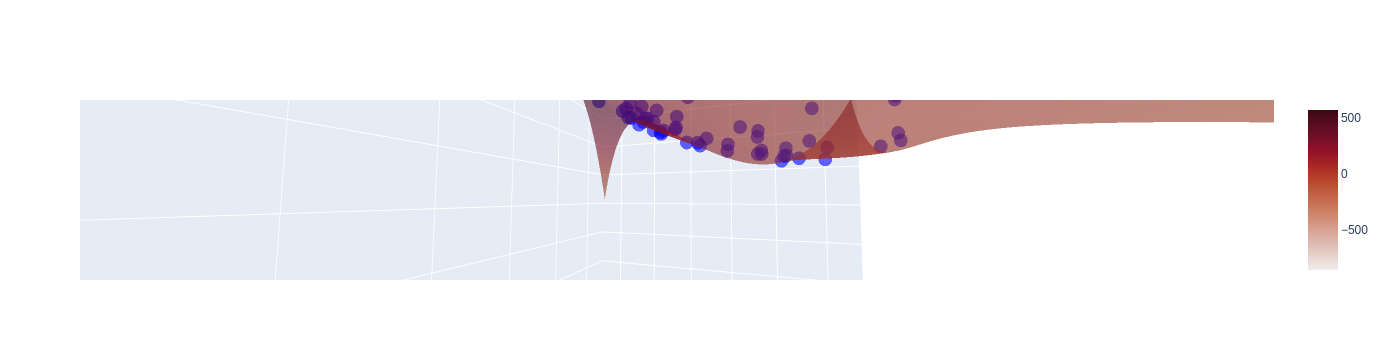

In [8]:
# Gerando os dados do polinômio
np.random.seed(0)
n_samples = 100
X = np.random.rand(n_samples, 2) * 10 # Duas variáveis exploratórias entre 0 e 10
coef = np.array([4, -3, 2]) # Coeficientes do polinômio verdadeiro: 2*X₁² - 3*X₂ + 4

y_true = np.dot(np.column_stack([X[:, 0]**2, X[:, 1], np.ones(n_samples)]), coef)
y_noise = np.random.normal(0, 2, n_samples) # Adicionando ruído aos dados
y = y_true + y_noise

# Criando a matriz de features polinomiais
poly = pp.PolynomialFeatures(degree=8, include_bias=True)
X_poly = poly.fit_transform(X)

# Treinando o modelo de regressão polinomial
model = lm.LinearRegression().fit(X_poly, y)

# Gerando pontos na malha para plotar a superfície de decisão
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
np.arange(x2_min, x2_max, 0.1))
X_mesh = np.column_stack([x1_mesh.ravel(), x2_mesh.ravel()])
X_mesh_poly = poly.transform(X_mesh)
y_mesh = model.predict(X_mesh_poly)
y_mesh = y_mesh.reshape(x1_mesh.shape)

# Criando o gráfico 3D
fig = go.Figure(data=[go.Scatter3d(x=X[:, 0], y=X[:, 1], z=y, mode='markers', marker=dict(color='blue', opacity=0.6), name='Dados'),
                go.Surface(x=x1_mesh, y=x2_mesh, z=y_mesh, colorscale='amp', opacity=0.6, name='Superfície de Decisão')])

# Configurando o layout do gráfico
fig.update_layout(scene=dict(xaxis_title='X1',yaxis_title='X2',zaxis_title='Y',aspectmode='auto'))

# Exibindo o gráfico
fig.show()

## **Decision tree regressor**

MSE:  23096.822628990925
RMSE:  151.976388393036


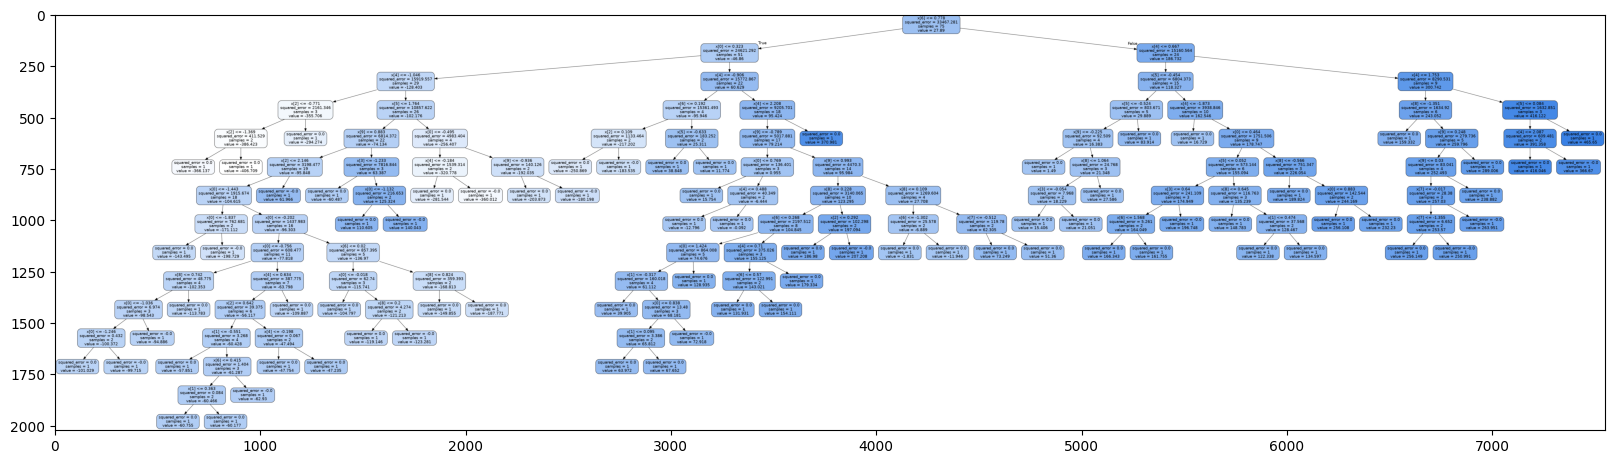

In [53]:
# Gerando dados sintéticos
X, y = dt.make_regression(n_features=10, random_state=42)

# Separando dados em treino e teste
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, random_state=0)

# Instanciando e treinando a Decision Tree Regressor
tree_reg = tr.DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

# Realizando a predição com os dados de teste
y_pred = tree_reg.predict(X_test)

# Calculando o erro médio quadrático (MSE) e RMSE
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE: ", mse)
print("RMSE: ", rmse)

# Export draw
dot_data = StringIO()
tr.export_graphviz(tree_reg,out_file='tree_reg.dot',rounded=True,filled=True)

# Convert .dot to .png
!dot -Tpng tree_reg.dot -o tree_reg.png

# Load image on jupyter notebook
img = cv2.imread('tree_reg.png')
plt.figure(figsize = (20, 20))
plt.imshow(img);

### **Com outliers**

MSE:  27487.048478618275
RMSE:  165.7921846125995


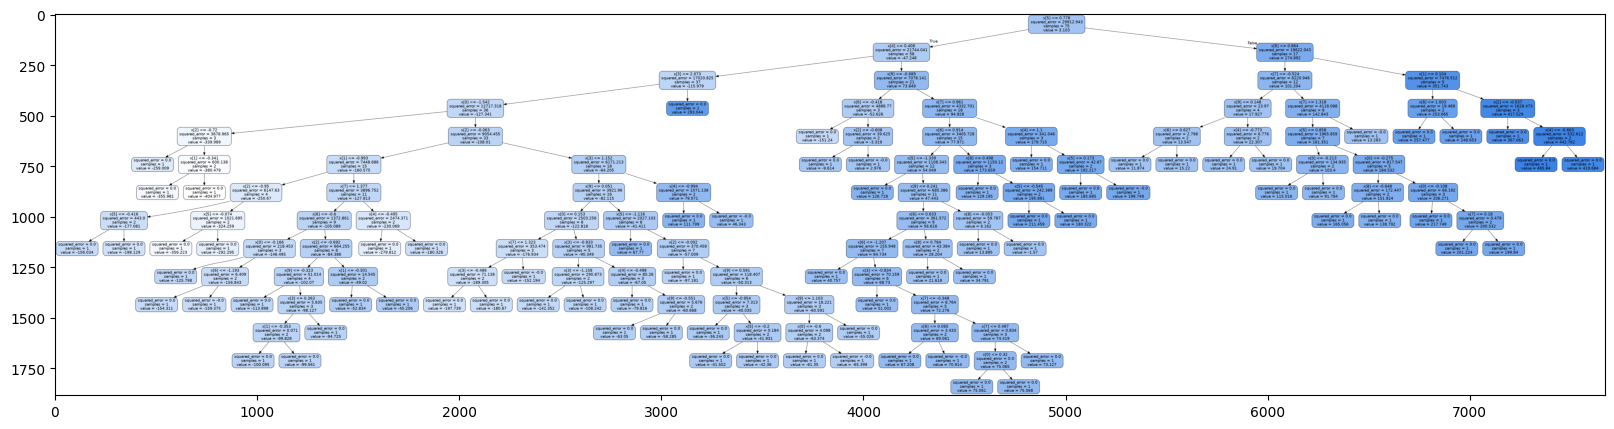

In [54]:
# Gerando dados sintéticos com ruído
X, y = dt.make_regression(n_features=10, random_state=42, noise=5)

# Separando dados em treino e teste
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, random_state=42)

# Instanciando e treinando a Decision Tree Regressor
tree_reg = tr.DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

# Realizando a predição com os dados de teste
y_pred = tree_reg.predict(X_test)

# Calculando o erro médio quadrático (MSE) e RMSE
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE: ", mse)
print("RMSE: ", rmse)

# Export draw
dot_data = StringIO()
tr.export_graphviz(tree_reg,out_file='tree_reg.dot',rounded=True,filled=True)

# Convert .dot to .png
!dot -Tpng tree_reg.dot -o tree_reg.png

# Load image on jupyter notebook
img = cv2.imread('tree_reg.png')
plt.figure(figsize = (20, 20));
plt.imshow(img);

### **Escalas diferentes**

MSE:  106914.91523069028
RMSE:  326.9784629462471


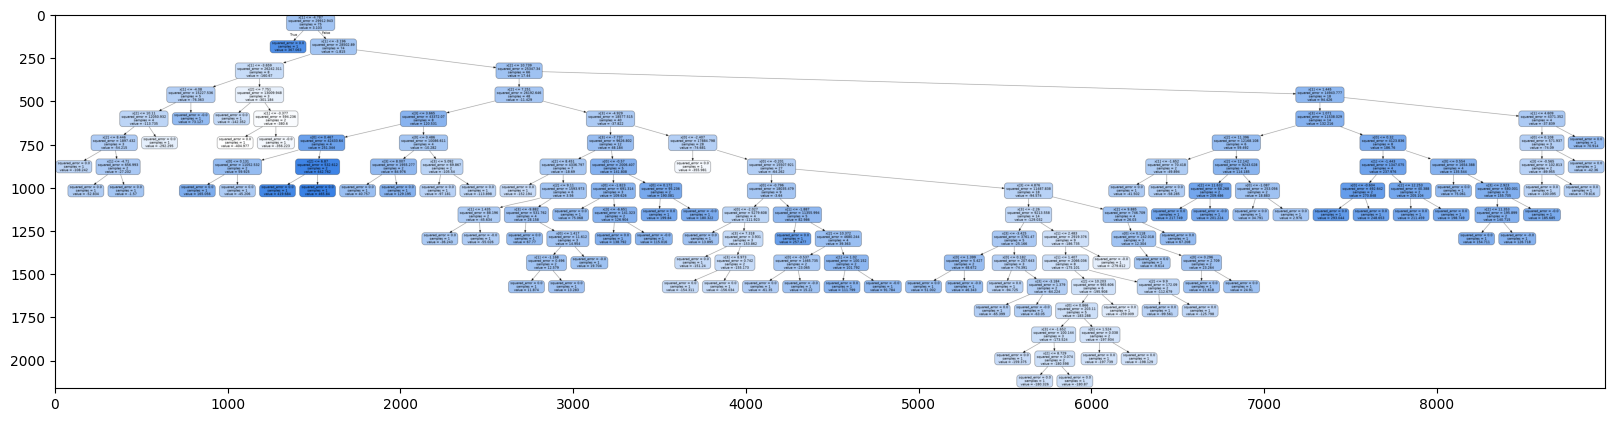

In [55]:
# Gerando dados sintéticos com ruído
X, y = dt.make_regression(n_features=10, random_state=42, noise=5)

# Generate synthetic data with different scales
X1 = np.random.normal(0, 1, size=(100, 1))
X2 = np.random.uniform(-5, 5, size=(100, 1))
X3 = np.random.normal(10, 2, size=(100, 1))
X4 = np.random.uniform(-10, 10, size=(100, 1))
X = np.hstack((X1, X2, X3, X4))

# Separando dados em treino e teste
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, random_state=42)

# Instanciando e treinando a Decision Tree Regressor
tree_reg = tr.DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

# Realizando a predição com os dados de teste
y_pred = tree_reg.predict(X_test)

# Calculando o erro médio quadrático (MSE) e RMSE
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE: ", mse)
print("RMSE: ", rmse)

# Export draw
dot_data = StringIO()
tr.export_graphviz(tree_reg,out_file='tree_reg.dot',rounded=True,filled=True)

# Convert .dot to .png
!dot -Tpng tree_reg.dot -o tree_reg.png

# Load image on jupyter notebook
img = cv2.imread('tree_reg.png')
plt.figure(figsize = (20, 20));
plt.imshow(img);

# **Classificação**

## **Knn**

In [30]:
# Carregamento dos dados
df = pd.read_csv('../ensaios/train.csv')

# Seleção de Features
features = ['idade', 'saldo_atual', 'divida_atual', 'renda_anual', 'valor_em_investimentos',
            'taxa_utilizacao_credito', 'num_emprestimos', 'num_contas_bancarias', 'num_cartoes_credito',
            'dias_atraso_dt_venc', 'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros']

label = ['limite_adicional']

# Preparação dos dados de treino
x_train = df.loc[:, features]
y_train = df.loc[:, label].values.ravel()

# Treinamento do algoritmo KNN
knn_classifier = KNeighborsClassifier(n_neighbors = 8).fit(x_train, y_train)

# Previsão das observações
y_pred = knn_classifier.predict(x_train)

# Comparação do Previsto com o Realizado
df1 = df.loc[:, ['id_cliente', 'limite_adicional']]
df1['predicted'] = y_pred

### **Performance**

In [38]:
# Confusion Matrix
print(mt.confusion_matrix(y_train, y_pred))

# Accuracy
print(f'Accuracy: {mt.accuracy_score(y_train, y_pred)}')

# Precisao
print(f"Precision: {mt.precision_score(y_train, y_pred, average='binary', pos_label='Conceder')}")

# Recall
print(f"Recall: {mt.recall_score(y_train, y_pred, average='binary', pos_label='Conceder')}")

# F1
print(f"F1: {mt.f1_score(y_train, y_pred, average='binary', pos_label='Conceder')}")

[[ 467 1038]
 [ 339 7656]]
Accuracy: 0.8550526315789474
Precision: 0.5794044665012407
Recall: 0.3102990033222591
F1: 0.4041540458675898


## **Logistic regression**

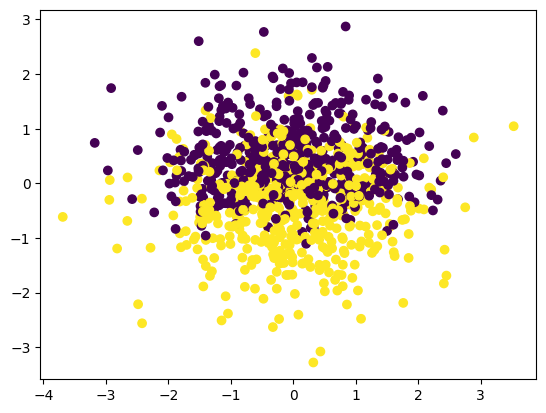

In [24]:
# Gerando um conjunto de dados de classificação aleatório
# X, y = make_classification(n_samples=1000, n_features=2, n_informative=1, n_redundant=0, n_clusters_per_class=1, random_state=42)
X, y = dt.make_classification(n_samples=1000, n_classes=2,random_state=42)

plt.scatter(X[:,0],X[:,1],c=y);

In [25]:
# Dividindo o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3, random_state=42)

# Instanciando o modelo de Regressão Logística
model = lm.LogisticRegression().fit(X_train, y_train)

# predict
## yhat_test = model.predict(X_test)
yhat_proba = model.predict_proba(X_test)
## poderia ser qualquer uma das duas colunas que o predict proba retorna, já que são probabilidades complementares de pertencer a classe 1
yhat_proba = yhat_proba[:, 1]
yhat = model.predict(X_test)

# Confusion Matrix
print(mt.confusion_matrix(y_test, yhat))

# # Accuracy
print(f"Accuracy: {mt.accuracy_score(y_test, yhat)}")

# # Precisao
print(f"Precision: {mt.precision_score(y_test, yhat, average='binary', pos_label=1)}")

# Recall
print(f"Recall: {mt.recall_score(y_test, yhat, average='binary', pos_label=1)}")

# F1
print(f"F1: {mt.f1_score(y_test, yhat, average='binary', pos_label=1)}")

[[127  18]
 [ 27 128]]
Accuracy: 0.85
Precision: 0.8767123287671232
Recall: 0.8258064516129032
F1: 0.8504983388704319


### **Curva precision x recall**

Model: f1=0.850 auc=0.927


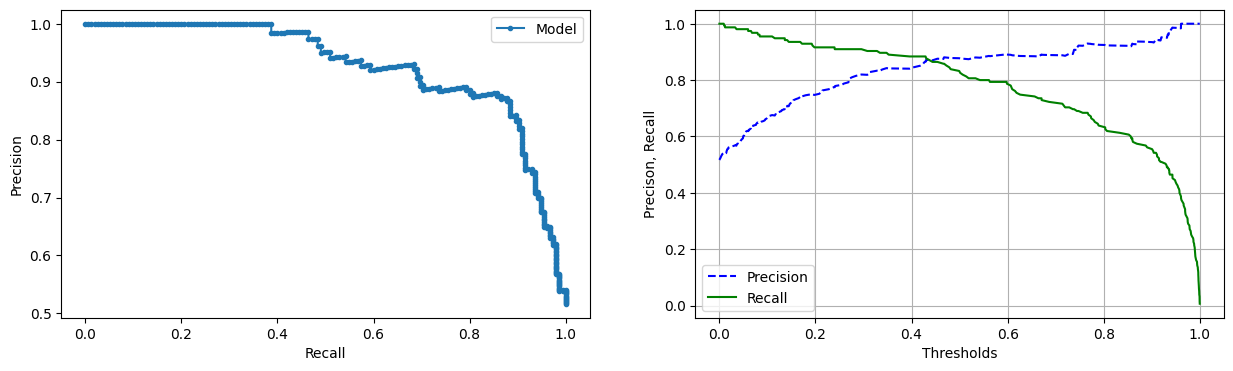

In [26]:
# curva precision x recall para dados muito dsbalanceados e curva roc para dados mais balanceados
# curva precision x recall é bom quando se tem preferência entre classes

# na prática o threshold começa a partir do 50%, pq abaixo disso apenas inverte as classes
# se for um problema multiclasse, usar one versus all
# se nao hover determinação do negócio, buscar o ponto no qual precision e recall sao o mais altos possíveis 

# predict class values
precision, recall, thresholds = precision_recall_curve(y_test, yhat_proba)
f1, auc = mt.f1_score(y_test, yhat), mt.auc(recall, precision)

# summarize scores
print('Model: f1=%.3f auc=%.3f' % (f1, auc))

fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])

# plot the precision-recall curves
ax1.plot(recall, precision, marker='.', label='Model')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
# [:-1] = todas as linhas menos a última
ax2.plot(thresholds, precision[:-1], 'b--', label='Precision');
ax2.plot(thresholds, recall[:-1], 'g-', label='Recall');
ax2.set_xlabel('Thresholds');
ax2.set_ylabel('Precison, Recall');
ax2.legend()
ax2.grid()

### **Curva roc**

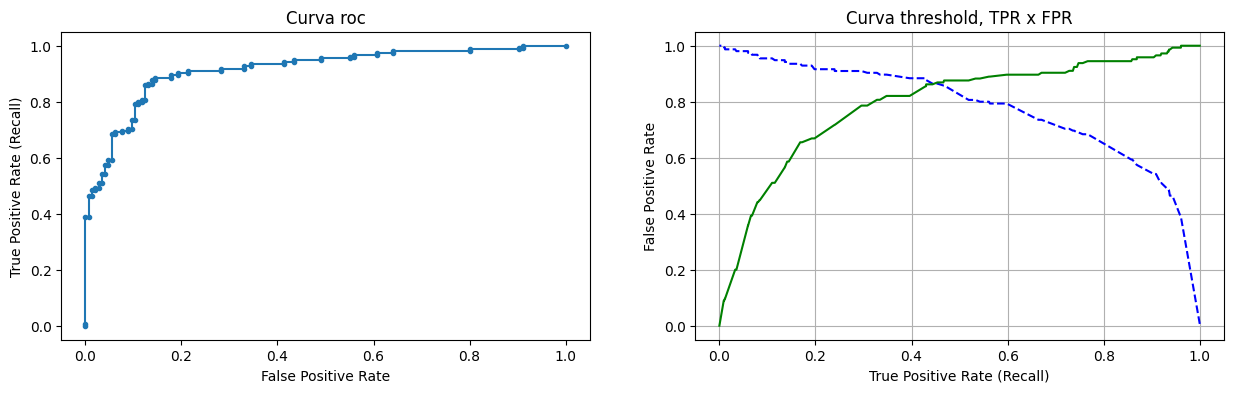

In [39]:
# bom para quando as duas classes tem o mesmo peso

# true positive rate = recall

# calculate roc curve
fpr, tpr, thresholds = mt.roc_curve(y_test, yhat_proba)

# calculate AUC
roc_auc = mt.auc(fpr, tpr)

# plot the roc curve 
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(fpr, tpr, marker='.', label='Model(AUC = %0.2f)' % roc_auc)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('Curva roc')

ax2 = fig.add_subplot(gs[0, 1])
# The optimal threshold is highest TPR e lowest FPR
ax2.plot(thresholds, tpr, 'b--', label='TPR');
# 1- = para plotar a relação correta entre tpr e fpr
ax2.plot(thresholds, 1-fpr, 'g-', label='FPR');
ax2.set_xlabel('True Positive Rate (Recall)');
ax2.set_ylabel('False Positive Rate');
ax2.set_title('Curva threshold, TPR x FPR')
ax2.grid()

### **Decision boundary**

In [5]:
# desenhar a reta 
# yhat=theta_0 (intercept) + theta_1(slope/coeficiente)*X1 + theta_2(slope/coeficiente)*X2 (X1 e X2 são as duas features do dataset)

theta_0=model.intercept_[0]
theta_1,theta_2=model.coef_.T

# cálculo do coeficiente angular (slope)
c=-theta_0/theta_2
# deslocamento da reta (intercepto)
m=-theta_1/theta_2

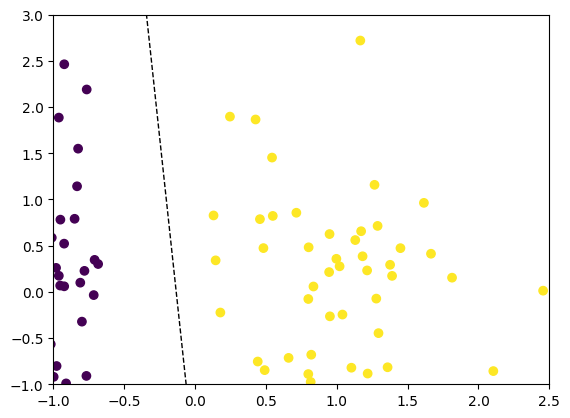

In [6]:
# descobrindo o valor mínimo e máximo dos dados
# np.min(X_train)
# np.max(X_train)

xmin, xmax = -1, 2.5
ymin, ymax = -1, 3.0
xd = np.array([xmin, xmax])
yd = m*xd + c

plt.plot(xd, yd, 'k', lw=1, ls='--')
# plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
# plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)
plt.scatter(X[:,0],X[:,1],c=y);
plt.xlim(xmin, xmax);
plt.ylim(ymin, ymax);

#### **Decision boundary com probabilidade**

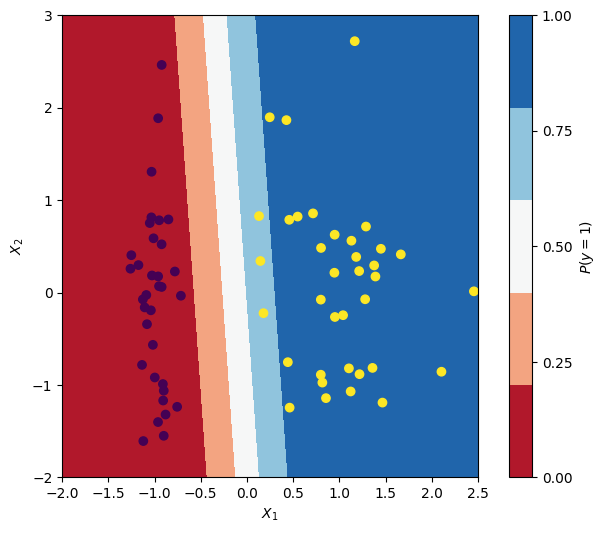

In [8]:
# desenhar um grid 
xx, yy = np.mgrid[-2:2.5:.01, -2:3:.01]

# tira do grid/matriz e transforma num array
grid = np.c_[xx.ravel(), yy.ravel()]

# calcular as probabilidades em cima do grid 
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

# Desenhar os contornos
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 5, cmap="RdBu", vmin=0, vmax=1)

# Barra de probabilidade
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
ax.scatter(X_train[:,0], X_train[:,1], c=y_train)
ax.set(aspect="equal",xlim=(-2, 2.5), ylim=(-2, 3),xlabel="$X_1$", ylabel="$X_2$");

## **Decision tree**

array([1])

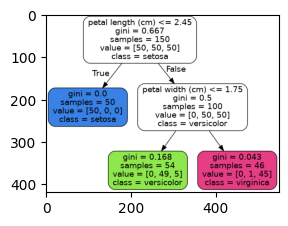

In [51]:
# Import dataset
iris = dt.load_iris()
X = iris.data[:, 2:]
y = iris.target

# Model fit
## max depth = controle do tamanho máximo de quebras da árvore
## min_sample_leaf =  n° mínimo de amostras que a folha precisa ter para se tornar uma folha
## min_sample_split = n° mínimo de amostras que a folha precisa ter para criar subdivisões

tree_clf = tr.DecisionTreeClassifier(max_depth=2).fit(X, y)

# Export draw
dot_data = StringIO()
tr.export_graphviz(tree_clf,out_file='tree.dot',feature_names=iris.feature_names[2:],
                   class_names=iris.target_names,rounded=True,filled=True)

# Convert .dot to .png
!dot -Tpng tree.dot -o tree.png

# Load image on jupyter notebook
img = cv2.imread('tree.png')
plt.figure(figsize = (3, 3))
plt.imshow(img)

# Predict
tree_clf.predict ([[5, 1.5]])

array([2])

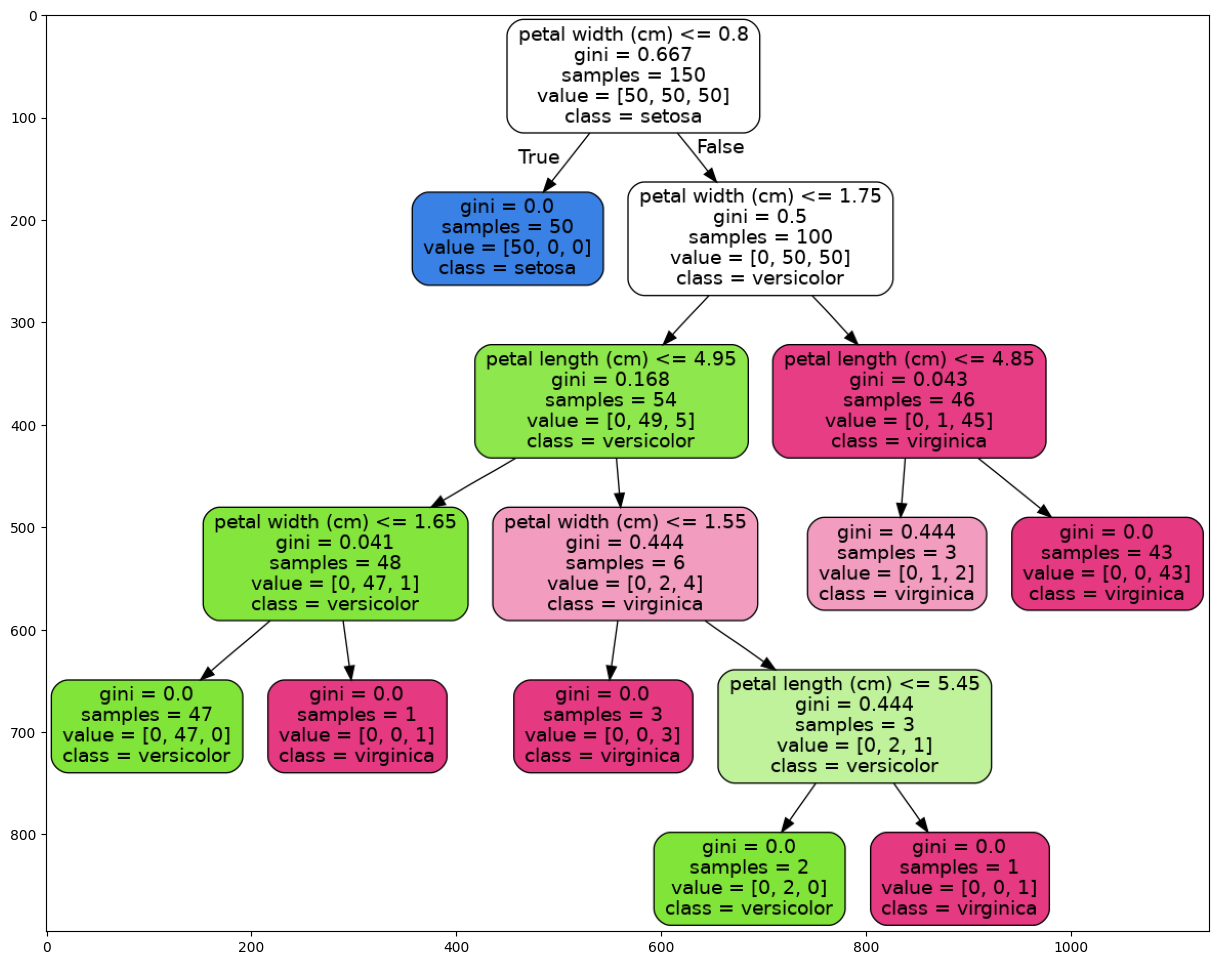

In [53]:
# Model fit
tree_clf = tr.DecisionTreeClassifier().fit(X, y)

# Export draw
dot_data = StringIO()
tr.export_graphviz(tree_clf,out_file='tree.dot',feature_names=iris.feature_names[2:],
                   class_names=iris.target_names,rounded=True,filled=True)

# Convert .dot to .png
!dot -Tpng tree.dot -o tree.png

# Load image on jupyter notebook
img = cv2.imread('tree.png')
plt.figure(figsize = (15, 15))
plt.imshow(img)

# Predict
tree_clf.predict ([[5, 1.5]])

## **Random forest** 

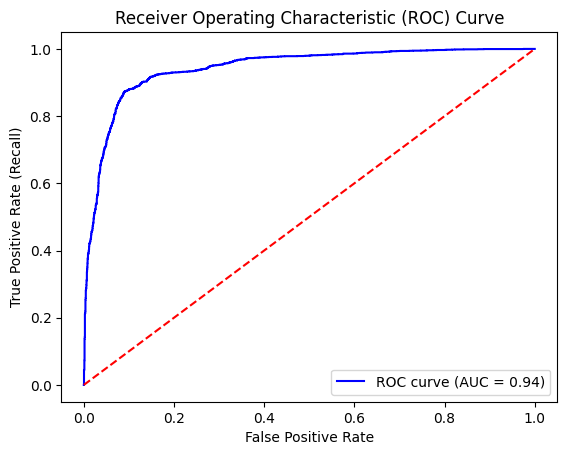

Best Threshold: 0.6760572631591804
Accuracy: 0.8914


In [61]:
# generate 2 class dataset
X, y = dt.make_classification(n_samples=10000, n_classes=2, random_state=42)

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# fit a model
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42).fit(X_train, y_train)

y_scores = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve values
fpr, tpr, thresholds = mt.roc_curve(y_test, y_scores)

# Calculate AUC score
auc_score = mt.roc_auc_score(y_test, y_scores)

# Plot ROC curve
plt.plot( fpr, tpr, color='b', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Find the best threshold based on ROC curve (usando a distância euclidiaana) (1- é pra inverter a curva para fazer o cálculo)
distances = np.sqrt((1 - tpr)**2 + fpr**2)
best_threshold = thresholds[np.argmin(distances)]
print(f"Best Threshold: {best_threshold}")

# Calculate accuracy using the best threshold
y_pred = (y_scores >= best_threshold).astype(int)
accuracy = mt.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# **Clusterização**

## **K-means**

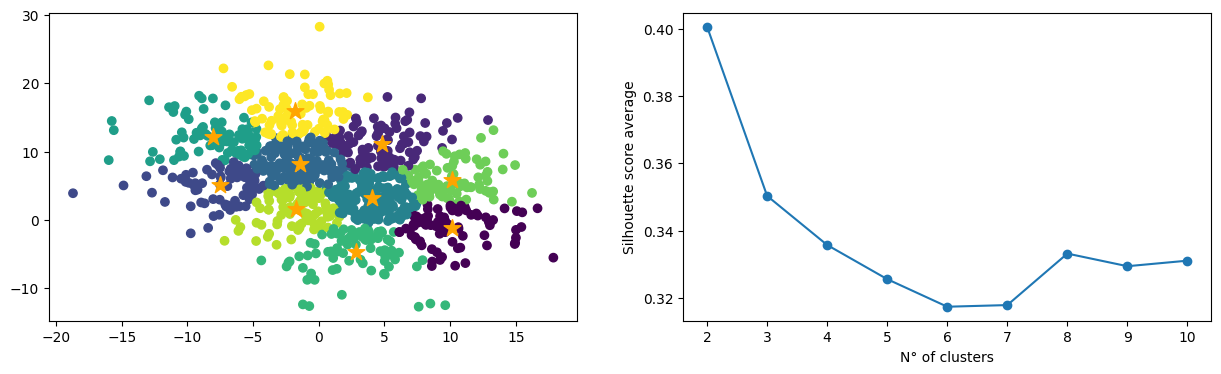

In [32]:
# Synthetic clustering dataset
X, y = dt.make_blobs( n_samples=1000, n_features=2, centers=2, cluster_std= 5,random_state=42)
# plt.scatter( X[:,0], X[:,1] )

# Training the cluster
n_clusters=np.arange(2,11,1)
ss_list=[]
for c in n_clusters:
    kmeans = ct.KMeans( n_clusters=c, init='random', n_init=10, random_state=42 )
    labels=kmeans.fit_predict(X)
    
    # performance
    ss_avg = mt.silhouette_score(X,labels)
    ss_list.append(ss_avg)
    # print(f'For n_clusters {c} the avg silhouette score is {ss_avg}')

fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])

# draw figure
ax1.scatter( X[:, 0], X[:, 1], c=kmeans.labels_ )
for i in range( len( kmeans.cluster_centers_ ) ):
    ax1.scatter( kmeans.cluster_centers_[i, 0],kmeans.cluster_centers_[i, 1],marker='*',c='orange',s=160 )

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(n_clusters,ss_list,marker='o')
ax2.set_xlabel('N° of clusters');
ax2.set_ylabel('Silhouette score average');

## **Affinity propagation**

In [71]:
# dataset
X = np.array( [[3, 4, 3, 2, 1],
               [4, 3, 5, 1, 1],
               [3, 5, 3, 3, 3],
               [2, 1, 3, 3, 2],
               [1, 1, 3, 2, 3]])

# training model
model = ct.AffinityPropagation()
model.fit( X )

# clustering data
labels = model.predict( X )
print( labels )

[0 0 0 1 1]


/home/soturno/.pyenv/versions/3.10.4/envs/ml/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Natural clusters: 4
Clusters identified: 151


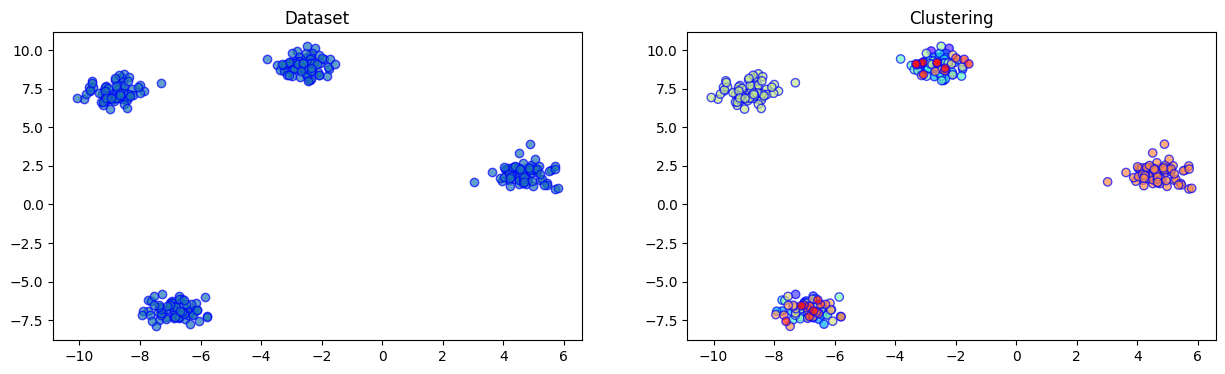

In [40]:
# dataset
X, _ = dt.make_blobs( n_samples=300, centers=4,cluster_std=0.5,random_state=42 )
# plt.scatter( X[:,0], X[:,1], alpha=0.7, edgecolors='b' );

# show dataset
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title( 'Dataset' )
ax1.scatter(X[:,0], X[:,1], alpha=0.7, edgecolors='b')

# training model
# model = ct.AffinityPropagation( preference=-50, max_iter=1000,convergence_iter=30)
model = ct.AffinityPropagation(preference=-90).fit( X )

# clustering data
labels = model.predict( X )
print('Natural clusters: 4')
print(f'Clusters identified: {len(np.unique(labels))}')

# show clusters
ax2 = fig.add_subplot(gs[0, 1])
# fig = plt.figure()
ax2.set_title( 'Clustering' )
# X[:,0], X[:,1] = todas as linhas da primeira e segunda colunas
ax2.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b');

### **Convergência visual**

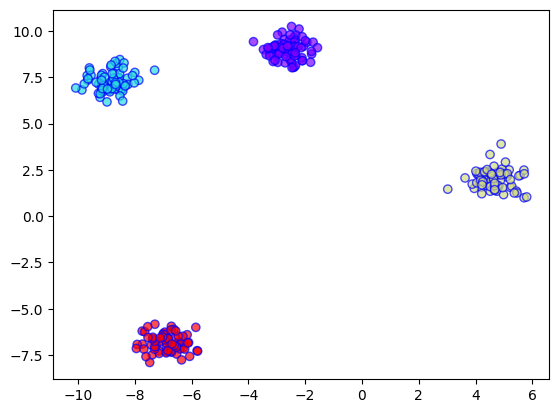

<Figure size 640x480 with 0 Axes>

In [68]:
X, _ = dt.make_blobs( n_samples=300, centers=4,cluster_std=0.5,random_state=42 )

# testing parameter
p = np.arange( -1, -61, -1 )
ss_list = []
fig = plt.figure()


for i in range( len( p ) ):    
    
    # model definition
    model = ct.AffinityPropagation( preference=p[i] ).fit( X )
    
    # clustering
    labels = model.predict( X )

    # plot
    plt.scatter( X[:,0], X[:,1], c=labels, cmap='rainbow', alpha=0.7,edgecolors='b' );
    clear_output( wait=True )
    plt.show();
    plt.gcf();
    time.sleep( 0.05 )

### **Convergência com métricas**

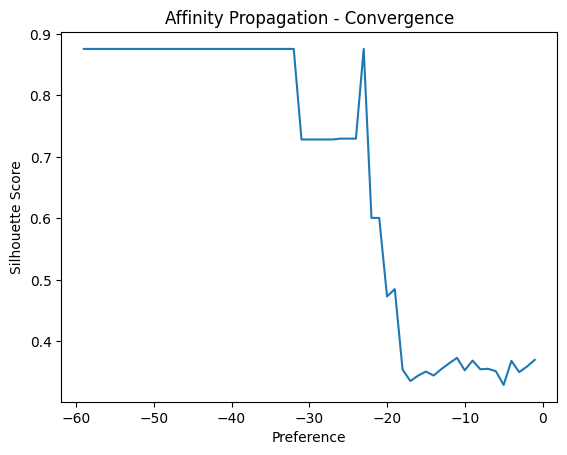

<Figure size 640x480 with 0 Axes>

In [73]:
# dataset
X, clusters = dt.make_blobs( n_samples=300, centers=4, cluster_std=0.60,random_state=42)

# show dataset
# plt.scatter(X[:,0], X[:,1], alpha=0.7, edgecolors='b')

# Convergency testing
p = np.arange( -1, -61, -1 )
ss_list = []

fig = plt.figure()
for i in range( len( p ) ):
    model = ct.AffinityPropagation( preference=p[i] ).fit( X )
    labels = model.predict( X )
    
    # Metric
    ss = mt.silhouette_score( X, labels )
    ss_list.append( ss )
    
    # Plot
    plt.plot( p[:i], ss_list[:i] )
    
    # Plot
    plt.title( 'Affinity Propagation - Convergence' );
    plt.xlabel( 'Preference' );
    plt.ylabel( 'Silhouette Score' )
    clear_output(wait=True)
    plt.show()
    plt.gcf()
    time.sleep(0.05)

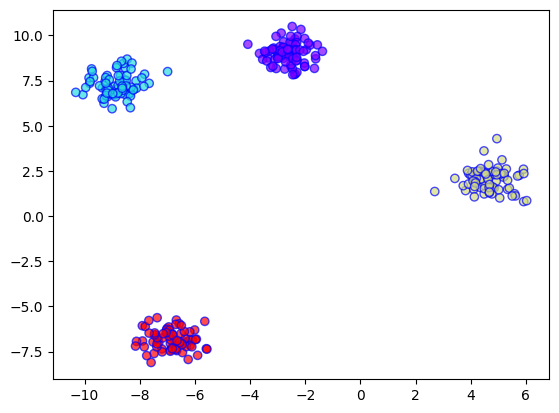

In [77]:
# Clustering with optimal preference
p_best=ss_list.index(max(ss_list))
af=ct.AffinityPropagation(preference=p[p_best]).fit(X)

labels = af.predict(X)
fig=plt.figure();

plt.scatter(X[:,0],X[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b');

# **Exercícios**

## **Classificação**

### **dataset real**

In [8]:
df = pd.read_csv('../ensaios/train.csv')

In [9]:
knn_classifier = KNeighborsClassifier(n_neighbors = 8)

cm1, acc1, prec1, recall1, f1_1 = class_separator(df,knn_classifier,5,5)
cm2, acc2, prec2, recall2, f1_2 = class_separator(df,knn_classifier,6,4)
cm3, acc3, prec3, recall3, f1_3 = class_separator(df,knn_classifier,7,3)
cm4, acc4, prec4, recall4, f1_4 = class_separator(df,knn_classifier,8,2)
cm5, acc5, prec5, recall5, f1_5 = class_separator(df,knn_classifier,9,1)

data = {
    'Neg/pos class': ['5/5', '6/4', '7/3', '8/2','9/1'],
    'Acurácia': [acc1, acc2, acc3, acc4, acc5],
    'Precisão': [prec1, prec2, prec3, prec4, prec5],
    'Recall': [recall1, recall2, recall3, recall4, recall5],
    'F1-Score': [f1_1, f1_2, f1_3, f1_4, f1_5]
}

df_knn = pd.DataFrame(data)


logistic_regressor = lm.LogisticRegression(solver='liblinear')

cm1, acc1, prec1, recall1, f1_1 = class_separator(df,logistic_regressor,5,5)
cm2, acc2, prec2, recall2, f1_2 = class_separator(df,logistic_regressor,6,4)
cm3, acc3, prec3, recall3, f1_3 = class_separator(df,logistic_regressor,7,3)
cm4, acc4, prec4, recall4, f1_4 = class_separator(df,logistic_regressor,8,2)
cm5, acc5, prec5, recall5, f1_5 = class_separator(df,logistic_regressor,9,1)

data = {
    'Neg/pos class': ['5/5', '6/4', '7/3', '8/2','9/1'],
    'Acurácia': [acc1, acc2, acc3, acc4, acc5],
    'Precisão': [prec1, prec2, prec3, prec4, prec5],
    'Recall': [recall1, recall2, recall3, recall4, recall5],
    'F1-Score': [f1_1, f1_2, f1_3, f1_4, f1_5]
}

df_log = pd.DataFrame(data)


dtc = tr.DecisionTreeClassifier(random_state=42)

cm1, acc1, prec1, recall1, f1_1 = class_separator(df,dtc,5,5)
cm2, acc2, prec2, recall2, f1_2 = class_separator(df,dtc,6,4)
cm3, acc3, prec3, recall3, f1_3 = class_separator(df,dtc,7,3)
cm4, acc4, prec4, recall4, f1_4 = class_separator(df,dtc,8,2)
cm5, acc5, prec5, recall5, f1_5 = class_separator(df,dtc,9,1)

data = {
    'Neg/pos class': ['5/5', '6/4', '7/3', '8/2','9/1'],
    'Acurácia': [acc1, acc2, acc3, acc4, acc5],
    'Precisão': [prec1, prec2, prec3, prec4, prec5],
    'Recall': [recall1, recall2, recall3, recall4, recall5],
    'F1-Score': [f1_1, f1_2, f1_3, f1_4, f1_5]
}

df_dt = pd.DataFrame(data)


rfc=RandomForestClassifier(random_state=42)

cm1, acc1, prec1, recall1, f1_1 = class_separator(df,rfc,5,5)
cm2, acc2, prec2, recall2, f1_2 = class_separator(df,rfc,6,4)
cm3, acc3, prec3, recall3, f1_3 = class_separator(df,rfc,7,3)
cm4, acc4, prec4, recall4, f1_4 = class_separator(df,rfc,8,2)
cm5, acc5, prec5, recall5, f1_5 = class_separator(df,rfc,9,1)

data = {
    'Neg/pos class': ['5/5', '6/4', '7/3', '8/2','9/1'],
    'Acurácia': [acc1, acc2, acc3, acc4, acc5],
    'Precisão': [prec1, prec2, prec3, prec4, prec5],
    'Recall': [recall1, recall2, recall3, recall4, recall5],
    'F1-Score': [f1_1, f1_2, f1_3, f1_4, f1_5]
}

df_rf = pd.DataFrame(data)

display_html(df_knn,df_log,df_dt,df_rf)

### **dataset artificial**

In [7]:
# Definir os classificadores
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=8),
    'Logistic Regression': lm.LogisticRegression(solver='liblinear'),
    'Decision Tree': tr.DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)}

# Definir as proporções das classes
proportions = [(0.5, 0.5),(0.6, 0.4),(0.7, 0.3),(0.8, 0.2),(0.9, 0.1)]

# Avaliar cada classificador e armazenar os resultados
results_dfs = {}
for name, clf in classifiers.items():
    results_dfs[name] = evaluate_classifier(clf, proportions)

# Acessar DataFrames dos resultados
df_knn = results_dfs['KNN']
df_log = results_dfs['Logistic Regression']
df_dt = results_dfs['Decision Tree']
df_rf = results_dfs['Random Forest']

display_html(df_knn,df_log,df_dt,df_rf)

## **Regressão**

In [ ]:
X, y = dt.make_regression(n_samples=10000, n_features=100, n_informative=10,  noise=0.0,  random_state=42)


lr_model = lm.LinearRegression()
lasso = lm.Lasso()
ridge = lm.Ridge() 
elastic_net = lm.ElasticNet()
ransac = lm.RANSACRegressor(stop_n_inliers=950)

poly = pp.PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X.reshape(-1, 1))
poly_model = lm.LinearRegression().fit(X_poly, y)

tree_reg = tr.DecisionTreeRegressor(random_state=42).fit(X_train, y_train)


r2_squared = np.round(100*mt.r2_score(y_train, y_pred), 2)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

def noise_specifier():
    
def evaluate_regressor():

In [ ]:
sss